In [2]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import branca
import branca.colormap as cm

In [3]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"

FILENAME = {}
FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]

In [47]:
from collections import Counter
raw_data = {}

raw_data['corona'] = pd.read_csv(corona,sep = '\t')
raw_data['metadata'] = pd.read_csv(meta,sep = '\t')
raw_data['shape'] = pd.read_csv(shape,sep = '\t')
raw_data['weather'] = pd.read_csv(weather,sep = '\t')

In [49]:
HEADERS = ['corona','weather']
for i in HEADERS:
    print(i +"  \tDataFrame shape: " + str(raw_data[i].shape))

corona  	DataFrame shape: (5602, 4)
weather  	DataFrame shape: (14904, 9)


In [43]:
def check_null_values(file):
    if raw_data[file].isnull().values.any():
        print('There are null values in the dataset')
    else:
        print('There are no null values in the dataset')

In [46]:
check_null_values('corona')

There are no null values in the dataset


In [53]:
weather_data_de = raw_data["weather"][raw_data["weather"]["iso3166-2"].str.startswith("DE")]
weather_data_de

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573
...,...,...,...,...,...,...,...,...,...
14861,2020-11-14,DE-SH,92.854723,7.043455e+05,2.429401e+06,283.769570,0.000243,0.033065,2.784840
14862,2020-11-14,DE-SL,87.575656,4.302501e+06,2.354934e+06,283.837352,0.000012,4.665761,3.050827
14863,2020-11-14,DE-SN,82.935273,2.388385e+06,2.362859e+06,283.909275,0.001199,2.795416,3.792073
14864,2020-11-14,DE-ST,85.289489,1.447632e+06,2.407647e+06,284.662583,0.000446,1.478117,2.738335


In [55]:
def dataset_checker_values(dataset,value):
    SA = dataset.copy()
    SA.replace(value, np.nan, inplace=True)
    missingdata_df = SA.columns[SA.isnull().any()].tolist()
    msno.matrix(SA);

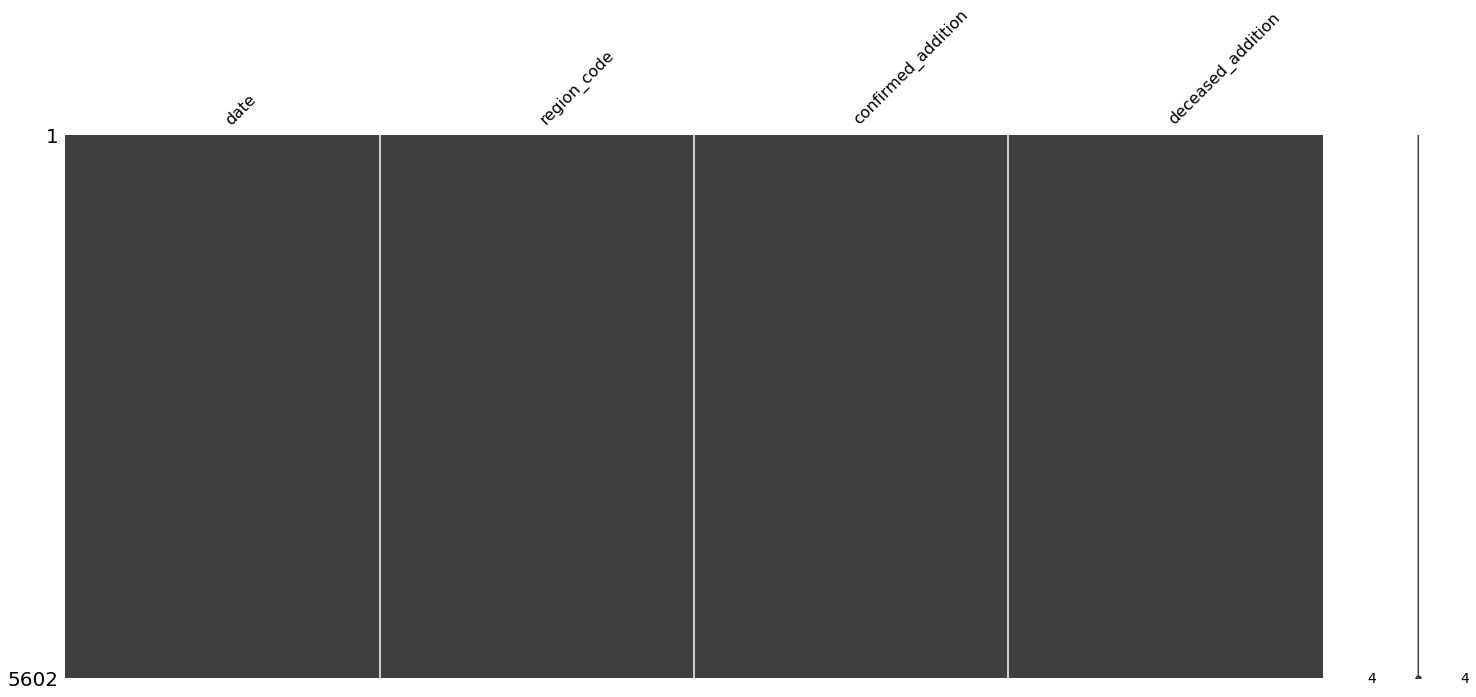

In [61]:
dataset_checker_values(raw_data['corona'],-999)